In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
data = pd.read_csv('bikes_rent.csv')

In [4]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


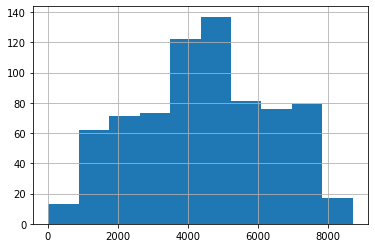

In [5]:
data['cnt'].hist();

In [0]:
X_df, y_series = data.drop('cnt', axis=1), data['cnt']

In [7]:
X_df.shape

(731, 12)

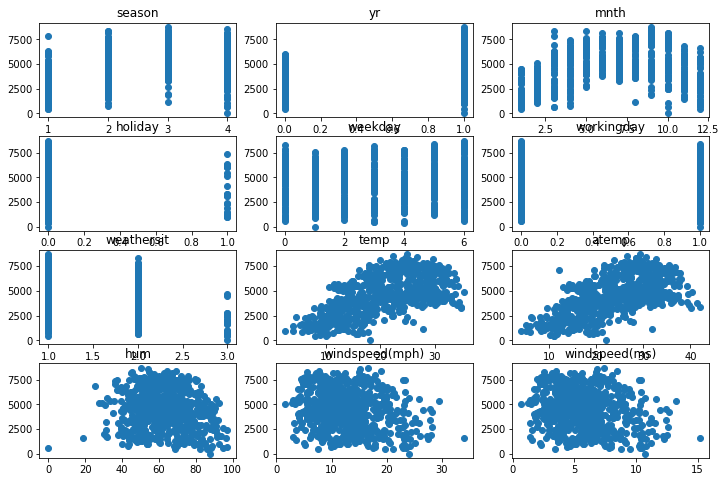

In [8]:
plt.figure(figsize=(12, 8))
#Строим график зависимости целевой переменной от каждого из признаков
for i, col in enumerate(X_df.columns):
    plt.subplot(4, 3, i + 1)
    plt.scatter(X_df[col], y_series)
    plt.title(col);

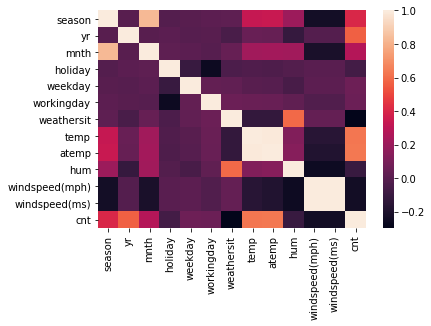

In [9]:
sns.heatmap(data.corr());

In [0]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

In [0]:
#смысл линейной комбинации также теряется, если признаки разных масштабов, поэтому масштабируем
ols = LinearRegression(normalize=True)

In [0]:
train_share = 0.7

train_part_len = int(train_share * data.shape[0])

X_train  = X_df.values[:train_part_len, :]
X_valid = X_df.values[train_part_len:, :]
y_train  = y_series.values[:train_part_len]
y_valid = y_series.values[train_part_len:]

In [0]:
from sklearn.metrics import mean_squared_error

In [41]:
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
y_ols_pred = ols.predict(X_valid)

In [0]:
def rmse(y, p):
    return np.sqrt(mean_squared_error(y, p))

In [0]:
def beautiful_coef(coefs, feature_names=X_df.columns):
    return pd.DataFrame(coefs, index=feature_names,
                       columns=['coef']).sort_values('coef',
                                                  ascending=False)
    

In [45]:
rmse(y_valid, y_ols_pred)

1121.7956200520618

In [46]:
#Видимо, что простой МНК пострадал от мультиколлинеарности наших данных, при windspeed в разных измерениями огромные веса (МНК так сделал, 
# чтоб компенсировать)
beautiful_coef(ols.coef_, feature_names=X_df.columns)

,coef
windspeed(ms),1.299317e+12
yr,2.111924e+03
season,3.737382e+02
atemp,1.113796e+02
weekday,5.185593e+01
workingday,3.170261e+01
mnth,9.011114e+00
temp,8.535154e+00
hum,-1.043745e+01
holiday,-4.139604e+02


In [50]:
lasso = Lasso(random_state=17, normalize=True)
lasso.fit(X_train, y_train)
y_lasso_pred = lasso.predict(X_valid)

1126.8667289649864

In [51]:
#Здесь уже не видим астрономических коэффициентов, Lasso поборолась, занулив некоторые признаки
beautiful_coef(lasso.coef_)

,coef
yr,2020.517017
season,362.520987
atemp,117.432310
weekday,42.037085
mnth,0.081720
workingday,0.000000
temp,0.000000
windspeed(ms),-0.000000
hum,-8.184440
windspeed(mph),-31.002820


In [52]:
rmse(y_valid, y_lasso_pred)

1126.8667289649864

In [0]:
ridge = Ridge(random_state=17, normalize=True)

In [59]:
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=17, solver='auto', tol=0.001)

In [60]:
#Гребневая регрессия уже никакие коэф-ты явно не заменила
beautiful_coef(ridge.coef_)

,coef
yr,893.471708
season,122.291657
workingday,44.899153
temp,43.335021
atemp,40.730731
weekday,23.657447
mnth,16.580342
hum,-6.019385
windspeed(mph),-14.569916
windspeed(ms),-32.592903


In [0]:
ridge_valid_pred = ridge.predict(X_valid)

In [62]:
rmse(y_valid, ridge_valid_pred)

1694.1963161505419

In [0]:
alphas = np.logspace(-4, 4, 100)

In [0]:
ridge_cv = RidgeCV(alphas=alphas,
                   cv=5, normalize=True).fit(X_train, y_train)

In [65]:
ridge_cv.alpha_

0.012618568830660211

In [0]:
best_ridge_valid_pred = ridge_cv.predict(X_valid)

In [67]:
#Самое лучшее
rmse(y_valid, best_ridge_valid_pred)

1118.803386608099

In [0]:
lasso = LassoCV(alphas=alphas, cv=5, normalize=True).fit(X_train, y_train)

In [69]:
lasso.alpha_

0.09770099572992257

In [0]:
best_lasso_valid_pred = lasso.predict(X_valid)

In [71]:
rmse(y_valid, best_lasso_valid_pred)

1120.7599048718082

In [72]:
beatiful_coef(lasso.coef_)

,coef
yr,2104.016880
season,371.889534
atemp,110.702588
weekday,50.803375
workingday,28.492832
temp,9.100711
mnth,8.227825
windspeed(ms),-0.000000
hum,-10.225836
windspeed(mph),-35.387183


In [36]:
beatiful_coef(ridge_cv.coef_)

,coef
yr,2086.883298
season,354.849868
atemp,70.048003
temp,52.872890
weekday,50.868024
workingday,34.406998
mnth,12.867755
hum,-10.225210
windspeed(mph),-18.579682
windspeed(ms),-41.562749


In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
forest = RandomForestRegressor(n_estimators=500, random_state=17)

In [80]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=17, verbose=0, warm_start=False)

In [0]:
forest_valid_pred = forest.predict(X_valid)

In [82]:
rmse(y_valid, forest_valid_pred)

1046.9607717751937

In [78]:
#Коэффициенты интерпретируются как важность признаков
#Лес - топ: ему не нужны масшт.данные, по кач-ву лучший результат дал, лес норм относится к выбросам, к мультиколлинеарности 
beatiful_coef(forest.feature_importances_)

,coef
temp,0.324132
atemp,0.216861
yr,0.200795
hum,0.067893
season,0.064054
weathersit,0.032349
mnth,0.028291
windspeed(ms),0.020298
weekday,0.018796
windspeed(mph),0.017695
